# Vision - Binary Image Classification

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of binary image classification with CNNs using the hot-dog/not-dog dataset on PyTorch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/


## Define transforms

Let's define a dictionary to hold the image transformations for train/test sets. 

In [5]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
#         transforms.Normalize([0.5, 0.5, 0.5],
#                              [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
#         transforms.Normalize([0.5, 0.5, 0.5],
#                              [0.5, 0.5, 0.5])
    ])
}

## Initialize Datasets

### Train + Validation Dataset

In [6]:
hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

hotdog_dataset

Dataset ImageFolder
    Number of datapoints: 498
    Root location: ../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

### Class <=> ID Mapping of Output

In [6]:
hotdog_dataset.class_to_idx

{'hot_dog': 0, 'not_hot_dog': 1}

In [7]:
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}
idx2class

{0: 'hot_dog', 1: 'not_hot_dog'}

In [8]:
def get_class_distribution(dataset):
    class_dist = {
        "hot_dog": 0,
        "not_hot_dog": 0
    }
    
    for img in dataset:
        if img[1] == 0:
            class_dist['hot_dog'] += 1
        elif img[1] == 1:
            class_dist['not_hot_dog'] += 1
            
    return class_dist

In [9]:
get_class_distribution(hotdog_dataset)

{'hot_dog': 249, 'not_hot_dog': 249}

### Get Train and Validation Samples

In [10]:
target_list = []

for _, t in hotdog_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [11]:
class_count = [i for i in get_class_distribution(hotdog_dataset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0040, 0.0040])

In [12]:
class_weights_all = class_weights[target_list]

In [13]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Test

In [14]:
hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )

hotdog_dataset_test

Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

## Train, Validation, and Test Dataloader

In [28]:
train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=8, sampler=weighted_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1)
test_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1)

## Explore The Data

Let's look at a single image.

In [29]:
single_batch = next(iter(train_loader))

`single_batch` is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels. 

Here's the first element of the list which is a tensor. This tensor is of the shape `(batch, channels, height, width)`. 

In [30]:
single_batch[0].shape

torch.Size([8, 3, 224, 224])

Here are the output labels for the batch.

In [31]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([1, 0, 1, 1, 1, 0, 0, 0])

Output label tensor shape:  torch.Size([8])


To plot the image, we'll use `plt.imshow` from matloptlib. It expects the image dimension to be `(height, width, channels)`. We'll `.permute()` our single image tensor to plot it. 

In [32]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

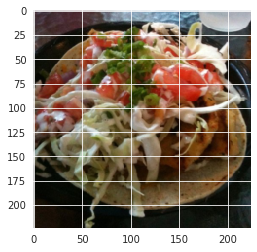

In [33]:
plt.imshow(single_image.permute(1, 2, 0))

PyTorch has made it easier for us to plot the images in a grid straight from the batch. 

We first extract out the image tensor from the list (returned by our dataloader) and set `nrow`. Then we use the `plt.imshow()` function to plot our grid. Remember to `.permute()` the tensor dimensions!

In [34]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

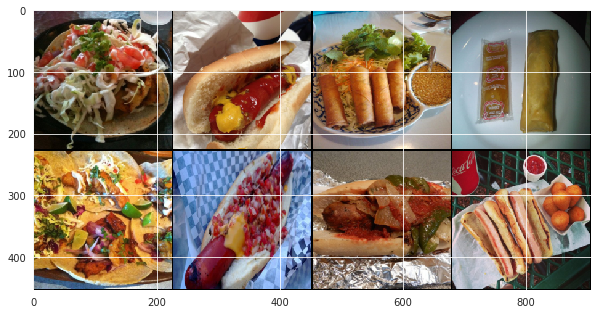

In [35]:
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Define a CNN Architecture

In [36]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
#         self.block4 = self.conv_block(c_in=64, c_out=32, dropout=0.1, kernel_size=3, stride=1, padding=1)
#         self.block5 = self.conv_block(c_in=32, c_out=16, dropout=0.1, kernel_size=3, stride=1, padding=1)
        
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        # input image size - [3, 128, 128]
        x = self.block1(x)
        
        # input image size - [256, 128, 128]
        x = self.maxpool(x)
        
        # input image size - [256, 64, 64]
        x = self.block2(x)
        
        # input image size - [128, 64, 64]
        x = self.block3(x)
        
        x = self.maxpool(x)
        
#         # input image size - [64, 64, 64]
#         x = self.block4(x)
 
#         # input image size - [32, 64, 64]
#         x = self.block5(x)

        # input image size - [2, 1, 1]
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block        

In [37]:
model = HotDogClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [38]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [39]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [40]:
print("Begin training.")

for e in tqdm(range(1, 21)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 137.75375 | Val Loss: 109.79471 | Train Acc: 54.778| Val Acc: 50.000
Epoch 002: | Train Loss: 32.00966 | Val Loss: 69.54856 | Train Acc: 62.127| Val Acc: 0.000
Epoch 003: | Train Loss: 16.21187 | Val Loss: 51.56977 | Train Acc: 64.048| Val Acc: 0.000
Epoch 004: | Train Loss: 7.96071 | Val Loss: 1.11673 | Train Acc: 68.841| Val Acc: 50.000
Epoch 005: | Train Loss: 3.45666 | Val Loss: 0.72575 | Train Acc: 75.048| Val Acc: 50.000
Epoch 006: | Train Loss: 1.85803 | Val Loss: 0.00000 | Train Acc: 79.032| Val Acc: 100.000
Epoch 007: | Train Loss: 1.02175 | Val Loss: 2.93583 | Train Acc: 79.333| Val Acc: 0.000
Epoch 008: | Train Loss: 0.59292 | Val Loss: 1.09566 | Train Acc: 87.413| Val Acc: 50.000
Epoch 009: | Train Loss: 0.48771 | Val Loss: 1.06258 | Train Acc: 84.508| Val Acc: 50.000
Epoch 010: | Train Loss: 0.20893 | Val Loss: 0.01032 | Train Acc: 92.794| Val Acc: 100.000
Epoch 011: | Train Loss: 0.28296 | Val Loss: 0.00013 | Train Acc: 90.460| Val Acc: 100.000
Ep

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

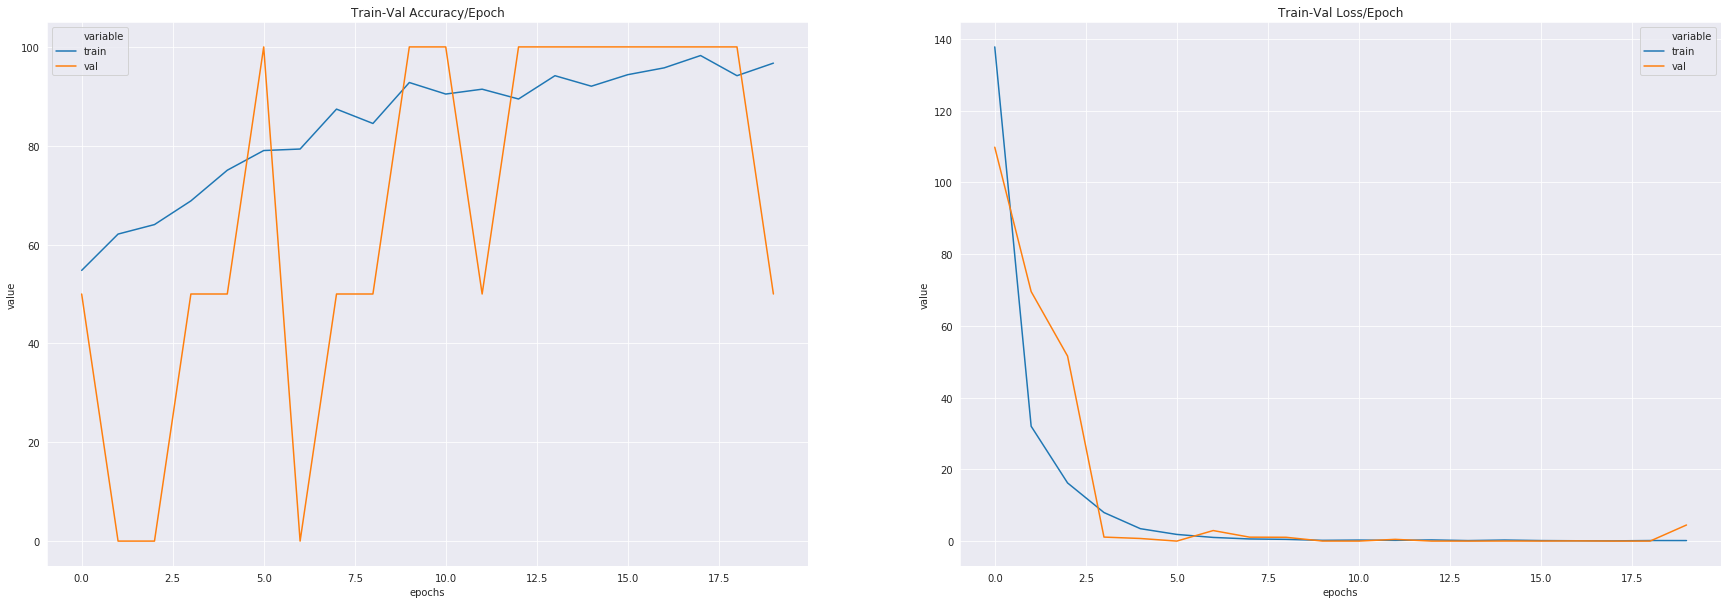

In [43]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [44]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [45]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [46]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       249
           1       0.97      1.00      0.99       249

    accuracy                           0.99       498
   macro avg       0.99      0.99      0.99       498
weighted avg       0.99      0.99      0.99       498



In [47]:
print(confusion_matrix(y_true_list, y_pred_list))

[[242   7]
 [  0 249]]


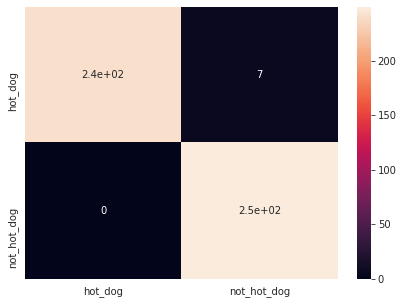

In [48]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)